In [104]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import unicodedata
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

In [76]:
#Read and cleanup
df = pd.read_csv('data/movie_all_english.csv')

indexes = df[ df['genre'] == 'News'].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'] == 'Game-Show'].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'] == 'Reality-TV'].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'] == 'Talk-Show'].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'] == 'Short'].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'] == 'Biography'].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'] == 'Film-Noir'].index
df.drop(indexes, inplace=True)
df.drop_duplicates(subset='movie', inplace=True)


In [23]:
df['genre_id'] = df['genre'].factorize()[0]
category_id_df = df[['genre', 'genre_id']].drop_duplicates().sort_values('genre_id')
categories = np.unique(df['genre'].values)
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['genre_id', 'genre']].values)
df.head()

,movie,genre,genre_id
0,Abracadabra,Musical,0
4,Bob's New Suit,Drama,1
5,Bad Dog and Superhero,Comedy,2
7,Academic,Drama,1
8,After the Wedding,Drama,1


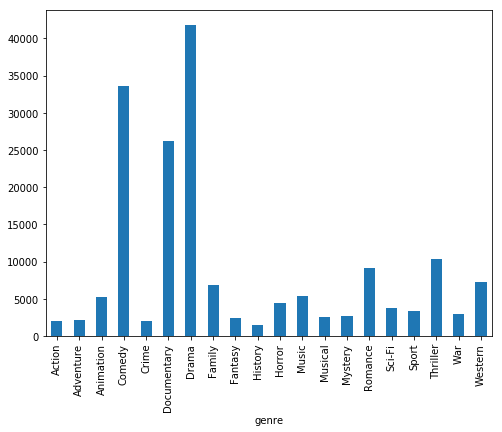

In [77]:
fig = plt.figure(figsize=(8,6))
df.groupby('genre').movie.count().plot.bar(ylim=0)
plt.show()

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.movie)
labels = df.genre_id
features.shape

(175850, 12241)

In [27]:
from sklearn.feature_selection import chi2
N = 2
for movie, genre_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == genre_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(movie))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Action':
  . Most correlated unigrams:
. ninja
. plebes
  . Most correlated bigrams:
. king fighters
. dos plebes
# 'Adventure':
  . Most correlated unigrams:
. tarzan
. bondage
  . Most correlated bigrams:
. nude bondage
. dangerous diva
# 'Animation':
  . Most correlated unigrams:
. hy
. moe
  . Most correlated bigrams:
. hy mayer
. mean moe
# 'Comedy':
  . Most correlated unigrams:
. comedy
. pimple
  . Most correlated bigrams:
. universal ike
. bobby bumps
# 'Crime':
  . Most correlated unigrams:
. crooks
. crime
  . Most correlated bigrams:
. small time
. vice academy
# 'Documentary':
  . Most correlated unigrams:
. america
. industry
  . Most correlated bigrams:
. playboy video
. panoramic view
# 'Drama':
  . Most correlated unigrams:
. fate
. woman
  . Most correlated bigrams:
. district attorney
. music awards
# 'Family':
  . Most correlated unigrams:
. magoo
. hare
  . Most correlated bigrams:
. image awards
. academy awards
# 'Fantasy':
  . Most correlated unigrams:
. herc

In [41]:
#Naive Bayes
x_train, x_val, y_train, y_val = train_test_split(df['movie'], df['genre'], random_state = 0)
count_vect = CountVectorizer()
x_counts = count_vect.fit_transform(df['movie'])
tfidf_transformer = TfidfTransformer()
x_tfidf = tfidf_transformer.fit_transform(x_counts)
clf = MultinomialNB().fit(x_tfidf, df['genre'])

In [42]:
print(clf.predict(count_vect.transform(["The killer"])))
print(clf.predict(count_vect.transform(["'Crocodile' Dundee II"])))
print(clf.predict(count_vect.transform(["Mystery Science Theater"])))
print(clf.predict(count_vect.transform(["Bee Movie"])))
print(clf.predict(count_vect.transform(["Ants"])))
print(clf.predict(count_vect.transform(["Zombie"])))


['Drama']
['Documentary']
['Documentary']
['Comedy']
['Documentary']
['Horror']


C:\Users\Matt\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Matt\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


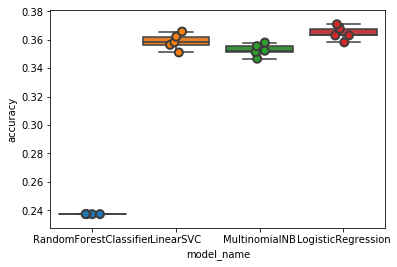

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [100]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit_transform([(c,) for c in df.genre])
labels = mlb.classes_
print(labels)
print(labels.shape)

filter_length = 300
max_words = 7500
maxlen = 400

num_classes = len(np.unique(df.genre))
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(df.movie)

def get_features(text_series):
    sequences = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(sequences, maxlen=maxlen)

def prediction_to_label(prediction):
    tag_prob = [(labels[i], prob) for i, prob in enumerate(prediction.tolist())]

def classify_movies():
    # create model
    model = Sequential()
    model.add(Embedding(max_words, 20, input_length=maxlen))
    model.add(Dropout(0.1))
    model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPool1D())
    model.add(Dense(20))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
    return model

['Action' 'Adventure' 'Animation' 'Comedy' 'Crime' 'Documentary' 'Drama'
 'Family' 'Fantasy' 'History' 'Horror' 'Music' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Sport' 'Thriller' 'War' 'Western']
(20,)


In [101]:
from sklearn.model_selection import train_test_split

x = get_features(df.movie)
y = mlb.fit_transform([(c,) for c in df.genre])
print(x.shape)
print(y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9000)

(175850, 400)
(175850, 20)


In [102]:
grouped_genre = df.groupby('genre').size().reset_index(name='count')
most_common_genre = grouped_genre.nlargest(num_classes, columns="count")

most_common_genre['class_weight'] = len(df['genre']) / most_common_tags['count']

class_weight = {}
for index, label in enumerate(labels):
    class_weight[index] = most_common_genre[most_common_tags['genre'] == label]['class_weight'].values[0]

In [105]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D

callbacks = [
    ReduceLROnPlateau(), 
    EarlyStopping(patience=4), 
    ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
]

model = classify_movies()
model.summary()

import tensorflow as tf


history = model.fit(x_train, y_train,
                    class_weight=class_weight,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 400, 20)           150000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 400, 20)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 398, 300)          18300     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                6020      
_________________________________________________________________
activation_4 (Activation)    (None, 20)                0         
Total params: 174,320
Trainable params: 174,320
Non-trainable params: 0
_________________________________________________________________
Trai

KeyboardInterrupt: 